# Preface

In this notebook, we investigate some issues with FCNN that is a little peculiar, namely its behavior with respect to permutations on image pixels.

In passing, we will also introduce some useful aspects of `keras`, namely
  * `Lambda` and `Flatten` layers as simple examples of preprocessing
  * the `evaluate` method to evaluate model performance
  * `get_weight` and `set_weight` methods to interact with variables in the model

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
sns.set(font_scale=1.5)
np.random.seed(123)

# Training a Simple Shallow NN for MNIST

We will train a simple one-hidden layer fully connected NN (FCNN) on the MNIST dataset. 

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Preprocessing Layers

Previously, we processed the input data in two ways
1. Normalize
```python
    x_train = x_train / 255
    x_test = x_test / 255
```
2. Reshape into vector
```python
    x_train = x_train.reshape(-1, 784)
    x_test = x_test.reshape(-1, 784)
```

Here, we show how these processes can be directly incorporated into `keras` layers. This is an alternative way to do things, with many advantages, e.g. if your preprocessing step is compute intensive, then doing this can greatly improve performance, as computations can be performed in parallel to training, and/or on the GPU. 

We will only perform the basic scaling and reshaping using ready-made `keras` layers. For more advanced usage, be sure to check the corresponding pre-processing modules available in keras
  * https://keras.io/preprocessing/image/
  * https://keras.io/preprocessing/sequence/

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Flatten

In [6]:
model = Sequential()

Metal device set to: Apple M2


2023-02-04 10:07:24.809150: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-04 10:07:24.809596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We will add first a normalization layer by dividing all pixel values by 255. This can be done using the `Lambda` layer, which is a flexible way to build custom layers.

**Remark** For backprop to work, it is *very* important that the function defining the Lambda layer be written in tensorflow to facilitate automatic differentiation. In other words, all math operations should either be performed using `tf.<some_op>` or those can be overloaded with tensorflow ops. In the example here, divide is overloaded, so that when you call `x/255` on a tensorflow tensor `x`, it is equivalent to calling `tf.math.divide(x, 255)`.

In [7]:
model.add(Lambda(lambda x: x / 255)) # use Lambda for custom layers!

Next, we perform the reshape operation to convert the input tensors from [:, 28, 28] to [:, 784]. This can be performed in three ways
  * `Reshape` layer, which requires us to specific the new shape
  * `Flatten` layer, which converts any tensor [:, a_1, a_2, ..., a_n] into [:, a_1*...*a_n]
  * `Lambda` layer, which you define what to do

We will use the `Flatten` since it is the simplest option here.

In [8]:
model.add(Flatten())

Now, let us build the rest of the network as usual.

In [9]:
model.add(Dense(128, activation='relu')) # single hidden layer
model.add(Dense(10, activation='softmax')) # 10 class classification, multiclass classification -> softmax (probability scores)

## Build and Train

To reduce clutter, we will use a progress bar callback. This is provided by `tqdm.keras`

In [10]:
from tqdm.keras import TqdmCallback

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    epochs=30,
    batch_size=128,
    verbose=0,
    callbacks=[TqdmCallback(verbose=1)]
)
results = pd.DataFrame(history.history)
results['epoch'] = history.epoch

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-02-04 10:07:24.986580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-04 10:07:25.390449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-04 10:07:29.104187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<AxesSubplot: xlabel='epoch'>

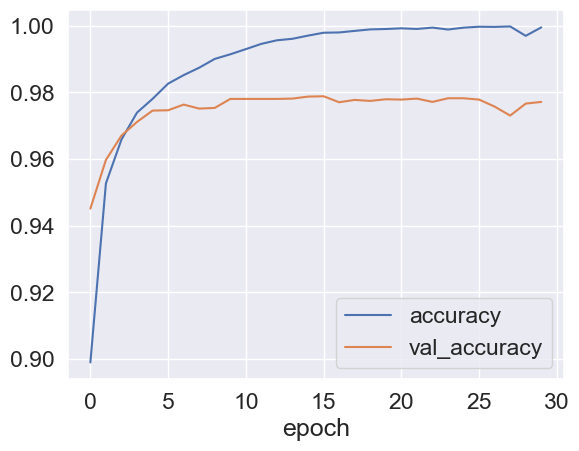

In [13]:
results.plot(x='epoch', y=['accuracy', 'val_accuracy'])

We can also write a handy function to evaluate performance on training and test sets, based on the `evaluate` method of models.

In [14]:
def evaluate(model, train_data, test_data):
    eval_train = model.evaluate(*train_data, batch_size=512, verbose=0) # eval performance on training data
    eval_test = model.evaluate(*test_data, batch_size=512, verbose=0) # eval performance on test data
    print(f'Train - loss = {eval_train[0]:.3f}, acc = {eval_train[1]:.3f} ')
    print(f'Test - loss = {eval_test[0]:.3f}, acc = {eval_test[1]:.3f} ')

In [15]:
evaluate(model, train_data=(x_train, y_train), test_data=(x_test, y_test))

Train - loss = 0.002, acc = 1.000 
Test - loss = 0.106, acc = 0.977 


# Permutations on Images

Now let us investigate what happens when we permute the pixels of these images. We first plot two images in the training set.

<AxesSubplot: >

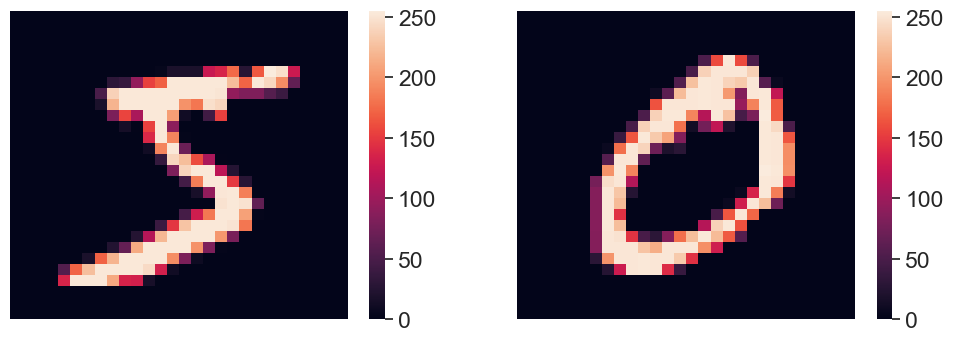

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(x_train[0], ax=ax1, xticklabels=[], yticklabels=[])
sns.heatmap(x_train[1], ax=ax2, xticklabels=[], yticklabels=[])

## Shuffling the Pixels Randomly

We write some functions for generating common permutations of images. Of course, there are much more efficient implementations of permutations in numpy. However, we are going to use pair-wise swaps to generate permutations.

**Remark** Recall that any permutation of $\{1,2,...,n\}$ can be decomposed into the composition of pair-wise swaps, so the latter indeed can generate any permutation.

In [17]:
def get_shuffle_indices(n):
    """
    Return permutation index formed by
    n pairwise swaps
    """
    shuf_idx = np.arange(784)
    for _ in range(n):
        i, j = np.random.choice(784, size=(2, ), replace=False)
        shuf_idx[i], shuf_idx[j] = shuf_idx[j], shuf_idx[i]
    return shuf_idx

def shuffle_image(image, shuf_idx):
    """
    Shuffle one or more images according
    to shuffle index shuf_idx
    """
    if image.ndim == 2:
        image = image[None, :, :]
    image = image.reshape(image.shape[0], -1)
    image = image[:, shuf_idx]
    return image.reshape(-1, 28, 28).squeeze()

def shuffle_and_eval(n_swap):
    # Shuffle by swapping
    print(f'Shuffle images by {n_swap} swaps')
    shuf_idx = get_shuffle_indices(n_swap)
    x_train_shuf = shuffle_image(x_train, shuf_idx)
    x_test_shuf = shuffle_image(x_test, shuf_idx)
    
    # Plot shuffled images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    sns.heatmap(x_train_shuf[0],
                ax=ax1,
                xticklabels=[],
                yticklabels=[])
    sns.heatmap(x_train_shuf[1],
                ax=ax2,
                xticklabels=[],
                yticklabels=[])

    evaluate(model, (x_train_shuf, y_train), (x_test_shuf, y_test))
    
    return shuf_idx, x_train_shuf, x_test_shuf

Now, let us look at the effect of permutation on the images and on model performance. The latter can be obtained by calling the `evaluate` method on models. It returns a list of values, starting with the loss and followed by the list of metrics provided in the `compile` method.

Shuffle images by 5000 swaps
Train - loss = 3.521, acc = 0.113 
Test - loss = 3.549, acc = 0.113 


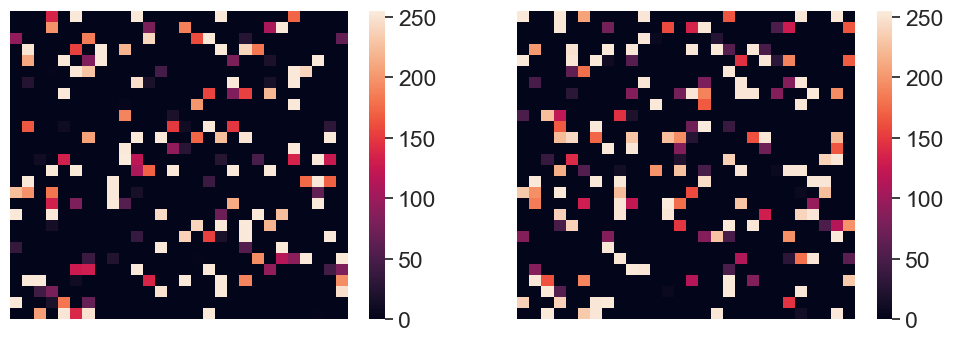

In [31]:
shuf_idx, x_train_shuf, x_test_shuf = shuffle_and_eval(n_swap=5000)

As we can see, once n_swaps is around 1000, to the human eye it is impossible to distinguish these images. As one may expect, the trained model also cannot distinguish the images, and gives an accuracy of about 10%, which is what one will get by randomly guessing.

## Can we really not handle permutations?

Does the above result mean that FCNN cannot deal with permuted images? The answer is no. It turns out that we don't even have to retrain the FCNN model to handle these with ease. 

We will do something with the `magic` function below to the trained model. Take a look at the function to understand what is going on. Also, note how to interact with the model weights by `get_weights` and `set_weights` methods.

**Note:** You can also achieve the same by using methods available from tensorflow 2.0 onwards, i.e.
```python
W, b, w, c = [w.numpy() for w in model.weights]  # same as model.get_weights()
```
and you can use the `assign` method available to tensors in model.weights to set weights individually.

In [19]:
def magic(model):
    """
    Shuffles the first kernel (W)
    by shuf_idx
    """
    W, b, w, c = model.get_weights()
    W_shuf = W[shuf_idx, :] # Given knowledge of the permutation, swap rows to obtain the required template
    model.set_weights([W_shuf, b, w, c])

In [20]:
magic(model)

In [21]:
evaluate(model, (x_train_shuf, y_train), (x_test_shuf, y_test))

Train - loss = 0.002, acc = 1.000 
Test - loss = 0.106, acc = 0.977 


## Exercise

Train a fresh FCNN model, but on randomly permuted images. Can they still be learned?

# Permutation and Convolutional Neural Networks

Let us now train a convolutional neural network for this model. We will use 3 convolution-maxpool blocks followed by a 2-hidden-layer FCNN as our network. This is a fairly simple network.

## Train and Evaluate a Simple CNN

In [22]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape

In [23]:
model = Sequential()

# Normalize and Reshape into [samples, height, width, channels]
model.add(Lambda(lambda x: x / 255))
model.add(Reshape((28, 28, 1)))

# Conv - Maxpool x 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D())

# Flatten - FC (2 hidden layers)
model.add(Flatten())
model.add(Dense(units=120, activation='relu'))
model.add(Dense(units=84, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We will check if a saved file containing trained weights exist. If not, train a new one and if so, load the model weights.

In [25]:
from pathlib import Path

In [26]:
save_path = Path('cnn_mnist_weights.h5')

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-02-04 10:09:18.000067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2023-02-04 10:09:32.206909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


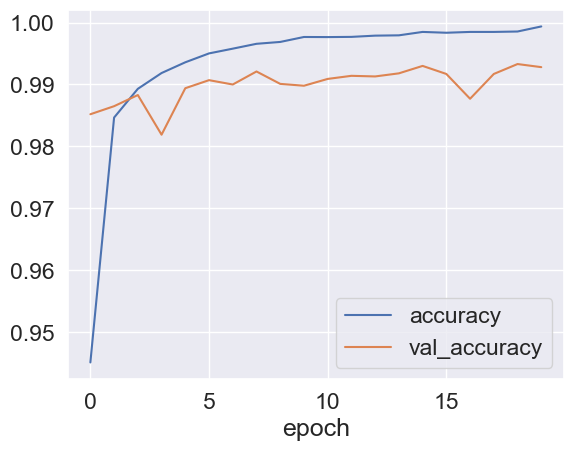

In [27]:
if save_path.exists():
    _ = model.predict(x_test, batch_size=512, verbose=0)  # call model once to make weights
    model.load_weights(filepath=str(save_path))
else:
    history = model.fit(
        x=x_train,
        y=y_train,
        validation_data=(x_test, y_test),
        epochs=20,
        batch_size=128,
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)]
    )
    results = pd.DataFrame(history.history)
    results['epoch'] = history.epoch
    results.plot(x='epoch', y=['accuracy', 'val_accuracy'])
    model.save_weights(str(save_path))

In [28]:
evaluate(model, (x_train, y_train), (x_test, y_test))

Train - loss = 0.001, acc = 1.000 
Test - loss = 0.033, acc = 0.993 


## Exercise

Train the above CNN on the permuted images. Do we still expect to get back the same accuracy?